In [1]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns

from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import plotly.express as px
import plotly.graph_objects as go
import glob

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os

In [2]:
path_input_data = '../input_time_series/'
dpd = 24 # data per day in the time serie
dpy = 365 # data per year :  cut the leap years to 365 years

ndpd = 64 # new data per day for hourly data (for the interpolation)
signal_length = ndpd * dpy

In [3]:
import seaborn as sn
from scipy.stats import pearsonr
list_lags = pd.read_csv("results/lags_world_diff_true.csv", index_col=0)

for country_name in list_lags.index :
    result_optim = pd.read_pickle(f'results/{country_name}/optimization_results.pickle')
    list_lags.loc[country_name,'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name,'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name,'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name, 'cf_pv']=result_optim['E_pv']/(result_optim['pv_capacity']*8760)
    list_lags.loc[country_name, 'cf_wind'] = result_optim['E_wind']/(result_optim['wind_capacity']*8760)
    # list_lags.loc[country_name, 'Pmin/Pmax PV'] = np.min(result_optim['optimized_pv'])/np.max(result_optim['optimized_pv'])
    # list_lags.loc[country_name, 'Pmin/Pmax Wind'] = np.min(result_optim['optimized_wind'])/np.max(result_optim['optimized_wind'])
    # list_lags.loc[country_name, 'Pmin/Pmax Load'] = np.min(result_optim['consumption'])/np.max(result_optim['consumption'])
    # list_lags.loc[country_name, 'Max Diff Wind/D']= np.max(result_optim['consumption']-result_optim['optimized_wind'])
    # list_lags.loc[country_name, 'Mean Diff Wind/D']= np.mean(result_optim['consumption']-result_optim['optimized_wind'])
    list_lags.loc[country_name, 'corr_load_wind']= pearsonr(result_optim['consumption'], result_optim['optimized_wind'])[0]
    list_lags.loc[country_name, 'corr_load_pv']= pearsonr(result_optim['consumption'], result_optim['optimized_pv'])[0]
    # print(country_name)
    betas = pd.read_excel(f'results_decomposition_coefficient/Plexos/{country_name}/results_betas_stacked.xlsx', header=None)
    list_lags.loc[country_name, 'beta_year'] = np.max(betas.iloc[:,2])
    list_lags.loc[country_name, 'max_beta_week'] = np.max(betas.iloc[:,1])
    list_lags.loc[country_name, 'max_beta_day'] = np.max(betas.iloc[:,0])

Calcul de correlation entre la conso et la prod éolienne

In [4]:
# result_optim = pd.read_pickle(f'results/France/optimization_results.pickle')
# from scipy.stats import pearsonr
# correlation, p_value = pearsonr(result_optim['consumption'], result_optim['optimized_wind'])

# print(f"Corrélation de Pearson : {correlation:.4f}")
# print(f"p-value : {p_value:.8f}")

Etude de la variance 

In [5]:
# Variance study
# verification du model
# var_echantillon = dataset['share_pv'].var()
# var_model = share_predict.var()
# # print(var_model/var_echantillon,model.score(X, y)) # Ok
# # 'if variance du modelalmost  equals to sample variance, model is validated')
# # On garde le model bivarié linéaire et on cherche les thermes pour Mass nulm et SCx nul
# # cf wind à zero
# dataset['Zero'] = np.zeros(dataset.shape[0])
# X_W = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'Zero']].to_numpy()
# share_predict_W = model.predict(X_W)
# var_du_cf_wind = share_predict_W.var()
# moy_du_cf_wind = share_predict_W.mean()
# # cf pv à zero
# X_PV = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'Zero', 'cf_wind']].to_numpy()
# share_predict_PV = model.predict(X_PV)
# var_du_PV = share_predict_PV.var()
# moy_du_PV = share_predict_PV.mean()
# # cf pv à zero
# X_WD = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Zero', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_WD = model.predict(X_WD)
# var_du_WD = share_predict_WD.var()
# moy_du_WD = share_predict_WD.mean()
# # cf pv à zero
# X_PVD = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Zero', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_PVD = model.predict(X_PVD)
# var_du_PVD = share_predict_PVD.var()
# moy_du_PVD = share_predict_PVD.mean()
# # lag wind week à zero
# X_WW= dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Zero','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_WW = model.predict(X_WW)
# var_du_WW = share_predict_WW.var()
# moy_du_WW = share_predict_WW.mean()
# # lag pv week à zero
# X_PVW = dataset[['Lag Wind Year', 'Lag PV Year', 'Zero', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_PVW = model.predict(X_PVW)
# var_du_PVW = share_predict_PVW.var()
# moy_du_PVW = share_predict_PVW.mean()
# # lag pv year à zero
# X_PVY= dataset[['Lag Wind Year', 'Zero', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_PVY = model.predict(X_PVY)
# var_du_PVY = share_predict_PVY.var()
# moy_du_PVY = share_predict_PVY.mean()
# # lag wind year à zero
# X_WY = dataset[['Zero', 'Lag PV Year', 'Zero', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_WY = model.predict(X_WY)
# var_du_WY = share_predict_WY.var()
# moy_du_WY = share_predict_WY.mean()

# # calcul du terme constant, on met a zero la masse et le SCx
# X_zero = dataset[['Zero', 'Zero','Zero', 'Zero','Zero', 'Zero','Zero', 'Zero']].to_numpy()
# share_predict_zero = model.predict(X_zero)
# var_du_a_zero = share_predict_zero.var()  # doit valoir 0
# moy_du_a_zero = share_predict_zero.mean()
# moy_du_cf_wind -= moy_du_a_zero
# moy_du_PV -= moy_du_a_zero
# moy_du_WD -= moy_du_a_zero
# moy_du_WY -= moy_du_a_zero
# moy_du_PVY -= moy_du_a_zero
# moy_du_PVW -= moy_du_a_zero
# moy_du_WW -= moy_du_a_zero
# moy_du_PVD -= moy_du_a_zero

# mean_tot = share_predict.mean()
# assert(abs(moy_du_a_zero + moy_du_cf_wind + moy_du_PV+moy_du_WD+moy_du_WY+moy_du_PVW+moy_du_PVY+ moy_du_WW+moy_du_PVD- mean_tot) / mean_tot < 1e-10)
# labels = ['Mass<sub>EV</sub>', 'A.Cd<sub>EV</sub>', 'Corr<sub>(Mass,ACd)</sub>', 'Others']
# var_values = [var_du_cf_wind, var_du_PV, var_model - (var_du_cf_wind + var_du_PV),
#                 var_echantillon - var_model]
# mean_values = {'Constant': moy_du_a_zero, 'Mass<sub>EV</sub>': var_du_cf_wind, 'A.Cd<sub>EV</sub>': var_du_PV}
# # return {'measure conso': measured_conso, 'measure range': measured_range, 'data': dataset, 'model': model,
# #         'a': a, 'b_ACd': b_SCx, 'c_Mass': c_Mass, 'errors': df_error, 'mean': mean_values,
# #         'variance': dict(zip(labels, var_values))}


In [6]:
# On supprime les lignes des pays qui sont subdivisés en états
list_lags = list_lags.drop(['United States', 'China', 'Australia', 'Brazil', 'Russia', 'Canada', 'Antarctica'])
list_lags['State']=None
list_lags['Country']=list_lags.index     

In [7]:
list_lags_states = pd.read_csv("results/lags_world_diff_states_3.csv")
regions_match = pd.read_excel('match_plexos_iso_codes.xlsx', index_col=1)
# list_lags_states=list_lags_states.reset_index()

list_lags_states = list_lags_states.set_index(['Country', 'State'])
list_lags_states = list_lags_states.sort_index()
for country, state_name in list_lags_states.index :
    regions_match_country = regions_match[regions_match['Country']==country]
    print(country, state_name)
    print(regions_match)
    region_name = regions_match_country.loc[state_name, 'plexos']
    # country_name = list_lags_states.loc[state_name, 'Country'].drop_duplicates().to_list()
    # print(country_name)
    # for country in country_name: 
    #     # if not type(country_name)==str: 
    #     #     country_name = country_name.iloc[0]
    result_optim = pd.read_pickle(f'results/{country}/optimization_results_{state_name}.pickle')
    list_lags_states.loc[(country, state_name),'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags_states.loc[(country, state_name),'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags_states.loc[(country, state_name),'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags_states.loc[(country, state_name), 'cf_pv']=result_optim['E_pv']/(result_optim['pv_capacity']*8760)
    list_lags_states.loc[(country, state_name), 'cf_wind'] = result_optim['E_wind']/(result_optim['wind_capacity']*8760)
    # list_lags_states.loc[state_name, 'Pmin/Pmax PV'] = np.min(result_optim['optimized_pv'])/np.max(result_optim['optimized_pv'])
    # list_lags_states.loc[state_name, 'Pmin/Pmax Wind'] = np.min(result_optim['optimized_wind'])/np.max(result_optim['optimized_wind'])
    # list_lags_states.loc[state_name, 'Pmin/Pmax Load'] = np.min(result_optim['consumption'])/np.max(result_optim['consumption'])
    # list_lags_states.loc[state_name, 'Max Diff Wind/D']= np.max(result_optim['consumption']-result_optim['optimized_wind'])
    # list_lags_states.loc[state_name, 'Mean Diff Wind/D']= np.mean(result_optim['consumption']-result_optim['optimized_wind'])
    list_lags_states.loc[(country, state_name), 'corr_load_wind']= pearsonr(result_optim['consumption'], result_optim['optimized_wind'])[0]
    list_lags_states.loc[(country, state_name), 'corr_load_pv']= pearsonr(result_optim['consumption'], result_optim['optimized_pv'])[0]
    betas = pd.read_excel(f'results_decomposition_coefficient/Plexos/{country}/{region_name}/results_betas_stacked.xlsx', header=None)
    list_lags_states.loc[(country, state_name), 'beta_year'] = np.max(betas.iloc[:,2])
    list_lags_states.loc[(country, state_name), 'max_beta_week'] = np.max(betas.iloc[:,1])
    list_lags_states.loc[(country, state_name), 'max_beta_day'] = np.max(betas.iloc[:,0])

Australia NT
          Country plexos
region                  
NSW     Australia     SW
QLD     Australia     QL
SA      Australia     SA
WA      Australia     WA
VIC     Australia     VI
...           ...    ...
CN044       China     GD
CN035       China     FU
CN023       China     HJ
CN041       China     HE
CN046       China     HA

[213 rows x 2 columns]


Australia NT
          Country plexos
region                  
NSW     Australia     SW
QLD     Australia     QL
SA      Australia     SA
WA      Australia     WA
VIC     Australia     VI
...           ...    ...
CN044       China     GD
CN035       China     FU
CN023       China     HJ
CN041       China     HE
CN046       China     HA

[213 rows x 2 columns]
Australia SA
          Country plexos
region                  
NSW     Australia     SW
QLD     Australia     QL
SA      Australia     SA
WA      Australia     WA
VIC     Australia     VI
...           ...    ...
CN044       China     GD
CN035       China     FU
CN023       China     HJ
CN041       China     HE
CN046       China     HA

[213 rows x 2 columns]
Australia SA
          Country plexos
region                  
NSW     Australia     SW
QLD     Australia     QL
SA      Australia     SA
WA      Australia     WA
VIC     Australia     VI
...           ...    ...
CN044       China     GD
CN035       China     FU
CN023       C

In [8]:
result = pd.concat([list_lags, list_lags_states])

In [9]:
# result = list_lags
# print(result)

# Régression multiple

In [10]:
result.keys()
dataset = result

In [11]:
dataset

,Lag PV Year,Lag Wind Year,Lag PV Week,Lag Wind Week,Lag PV Day,Lag Wind Day,share_wind,share_pv,share_dispatch,cf_pv,cf_wind,corr_load_wind,corr_load_pv,beta_year,max_beta_week,max_beta_day,State,Country
Afghanistan,1462,2756,138,63,11,1,0.178950,0.692404,0.128646,0.246219,0.107786,0.181089,0.037998,0.152531,0.064317,0.056329,None,Afghanistan
Albania,5449,7067,129,14,2,9,0.308150,0.577093,0.114756,0.174821,0.159912,-0.016512,0.575879,0.034325,0.074168,0.050510,None,Albania
Algeria,12857,3685,136,37,8,27,0.584352,0.297513,0.118135,0.213016,0.461972,-0.086221,0.131061,-0.007605,0.034232,0.008280,None,Algeria
Angola,9547,9634,53,86,10,22,0.113216,0.732760,0.154024,0.185640,0.179414,-0.120920,0.302828,-0.004394,0.057201,0.012460,None,Angola
Argentina,2229,2109,267,307,12,10,0.710703,0.207492,0.081805,0.189089,0.361690,0.142142,0.136801,0.009597,0.014407,0.067611,None,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(United States, PA)",1594,17864,265,5,10,5,0.318214,0.538224,0.143562,0.168506,0.229472,0.016988,0.229181,0.025067,0.173357,0.269776,NaN,NaN
"(United States, RI)",5449,9784,55,251,10,6,0.327920,0.536848,0.135232,0.171318,0.279625,-0.013585,0.284918,0.012351,0.180143,0.254666,NaN,NaN
"(United States, SC)",3190,17539,201,86,9,21,0.313670,0.540170,0.146160,0.178544,0.224505,-0.093722,0.177565,0.037431,0.126079,0.253997,NaN,NaN
"(United States, SD)",5639,7089,262,102,6,23,0.430679,0.455488,0.113833,0.183211,0.418283,-0.099879,0.326558,0.021310,0.076980,0.182707,NaN,NaN


In [34]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os


X = dataset[[ 'Lag PV Year','Lag Wind Year','Lag PV Week', 'Lag Wind Week', 'Lag PV Day', 'Lag Wind Day','cf_pv', 'cf_wind', 'corr_load_wind','corr_load_pv','max_beta_day', 'max_beta_week','beta_year']]
# X = dataset[[ 'Lag PV Year','Lag Wind Year', 'Lag PV Week', 'Lag Wind Week', 'Lag PV Day', 'Lag Wind Day','cf_pv', 'cf_wind', 'max_beta_day', 'max_beta_week', 'beta_year']]
y = dataset['share_pv']
# print(X.isna().sum())
X_clean = X.dropna()
y = y[X.index.isin(X_clean.index)] 
dataset = dataset[X.index.isin(X_clean.index)] 
X=X_clean # Adjust y accordingly if rows are dropped from X
model = LinearRegression()
model.fit(X, y)
model.score(X, y)  # R²
print(model.score(X, y))
share_predict = model.predict(X)

coef = model.coef_
a = model.intercept_
dataset['Prediction share Wind'] = share_predict
# Model Evaluation
meanAbErr = metrics.mean_absolute_error(y, share_predict)
meanSqErr = metrics.mean_squared_error(y, share_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y, share_predict))

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print(f'Coefficient de détermination (R²): {model.score(X, y)}')

0.7818314225670921
Mean Absolute Error: 0.058945969058424974
Mean Square Error: 0.005916691890264491
Coefficient de détermination (R²): 0.7818314225670921


On ajoute maintenant les prédicteurs un par un pour voir l'évolution du R2.

In [35]:
# dataset = result
# X = dataset[['cf_wind']]
# y = dataset['share_pv']

# model = LinearRegression()
# model.fit(X, y)
# model.score(X, y)  # R²
# print(model.score(X, y))
# share_predict = model.predict(X)

# coef = model.coef_
# a = model.intercept_

# dataset['Prediction share PV'] = share_predict
# # Model Evaluation
# meanAbErr = metrics.mean_absolute_error(y, share_predict)
# meanSqErr = metrics.mean_squared_error(y, share_predict)
# rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y, share_predict))

# print('Mean Absolute Error:', meanAbErr)
# print('Mean Square Error:', meanSqErr)
# print(f'Coefficient de détermination (R²): {model.score(X, y)}')

# Analyse de la variance

Coefficients estimés : [-2.81943298e-06  6.88926148e-07 -2.08762842e-05 -1.16170730e-05
  1.99525525e-03  6.85624714e-04  2.47596265e+00 -5.13355225e-01
 -1.72237982e-01  9.02598845e-02  2.02854201e-01 -4.62867187e-01
 -2.11070409e-01]
Erreur quadratique moyenne (MSE) : 0.006771354006805415
Coefficient de détermination (R^2) : 0.7567669631700307

Analyse de la variance (ANOVA) pour chaque paramètre (variables quantitatives) :
Paramètre Lag PV Year: F-value = 72.23, p-value = 6.38e-16
Paramètre Lag Wind Year: F-value = 82.93, p-value = 7.87e-18
Paramètre Lag PV Week: F-value = 0.11, p-value = 7.42e-01
Paramètre Lag Wind Week: F-value = 11.60, p-value = 7.40e-04
Paramètre Lag PV Day: F-value = 1.04, p-value = 3.07e-01
Paramètre Lag Wind Day: F-value = 16.87, p-value = 5.04e-05
Paramètre cf_pv: F-value = 270.50, p-value = 5.67e-45
Paramètre cf_wind: F-value = 99.28, p-value = 1.18e-20
Paramètre corr_load_wind: F-value = 90.16, p-value = 4.31e-19
Paramètre corr_load_pv: F-value = 192.59, p

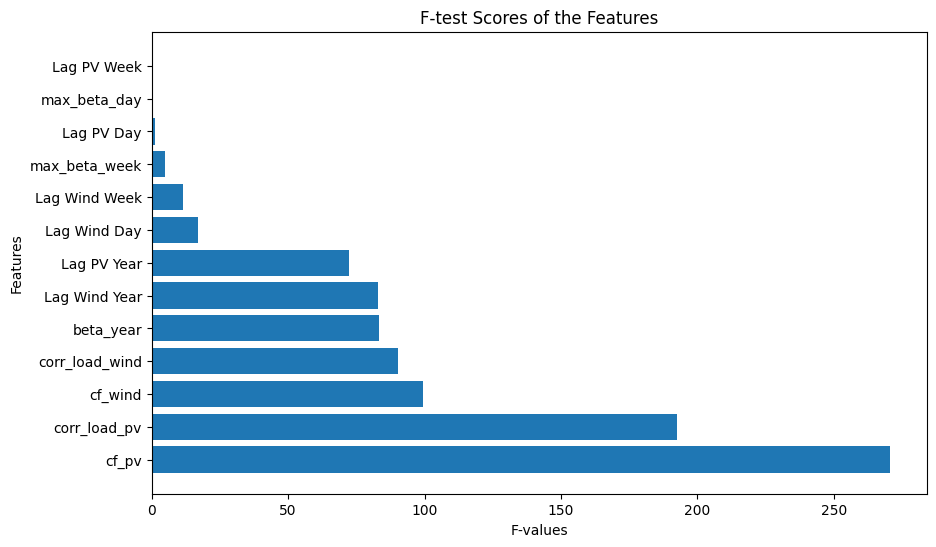

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression


# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation des performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Analyse de la variance (ANOVA) dans le contexte de la régression linéaire
f_values, p_values = f_regression(X, y)

# Affichage des résultats
print("Coefficients estimés :", model.coef_)
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R^2) :", r2)
print("\nAnalyse de la variance (ANOVA) pour chaque paramètre (variables quantitatives) :")
for i, col in enumerate(X.columns):
    print(f"Paramètre {col}: F-value = {f_values[i]:.2f}, p-value = {p_values[i]:.2e}")

plt.figure(figsize=(10, 6))
indices = np.argsort(f_values)[::-1]
plt.barh(range(X.shape[1]), f_values[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylabel('Features')
plt.xlabel('F-values')
plt.title('F-test Scores of the Features')
plt.show()

# Random Forest

RF train accuracy: 0.970
RF test accuracy: 0.801
Erreur quadratique moyenne (MSE) : 0.005541613717951761
Coefficient de détermination (R^2) : 0.8009403241653973

Importance des variables :
Lag PV Year: Importance = 0.0370
Lag Wind Year: Importance = 0.0235
Lag PV Week: Importance = 0.0156
Lag Wind Week: Importance = 0.0139
Lag PV Day: Importance = 0.0189
Lag Wind Day: Importance = 0.0175
cf_pv: Importance = 0.5454
cf_wind: Importance = 0.1813
corr_load_wind: Importance = 0.0512
corr_load_pv: Importance = 0.0464
max_beta_day: Importance = 0.0128
max_beta_week: Importance = 0.0146
beta_year: Importance = 0.0221


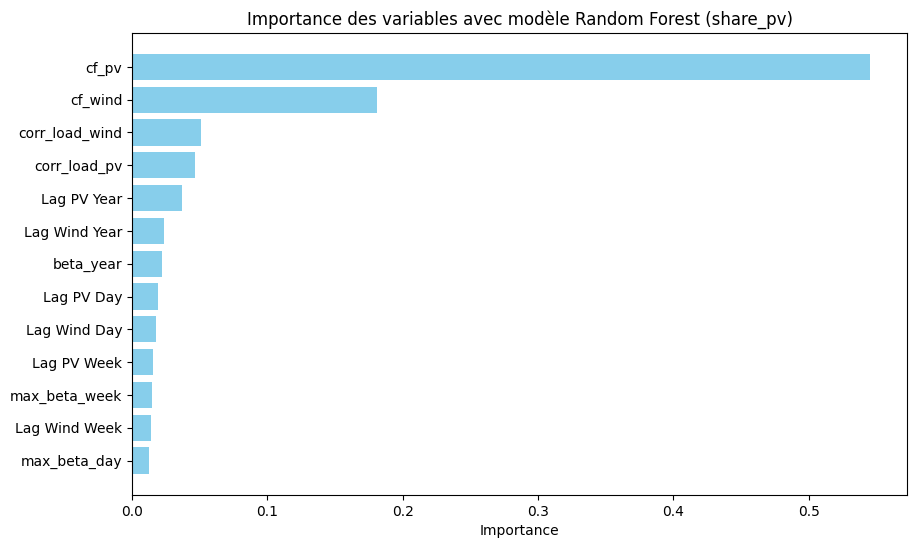

In [37]:
from sklearn.ensemble import RandomForestRegressor
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialisation du modèle de forêt aléatoire
model = RandomForestRegressor(random_state=0)

# Entraînement du modèle
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RF train accuracy: {model.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {model.score(X_test, y_test):.3f}")
importances = model.feature_importances_

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R^2) :", r2)
print("\nImportance des variables :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance = {importances[i]:.4f}")

sorted_idx = importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.title('Importance des variables avec modèle Random Forest (share_pv)')
plt.show()

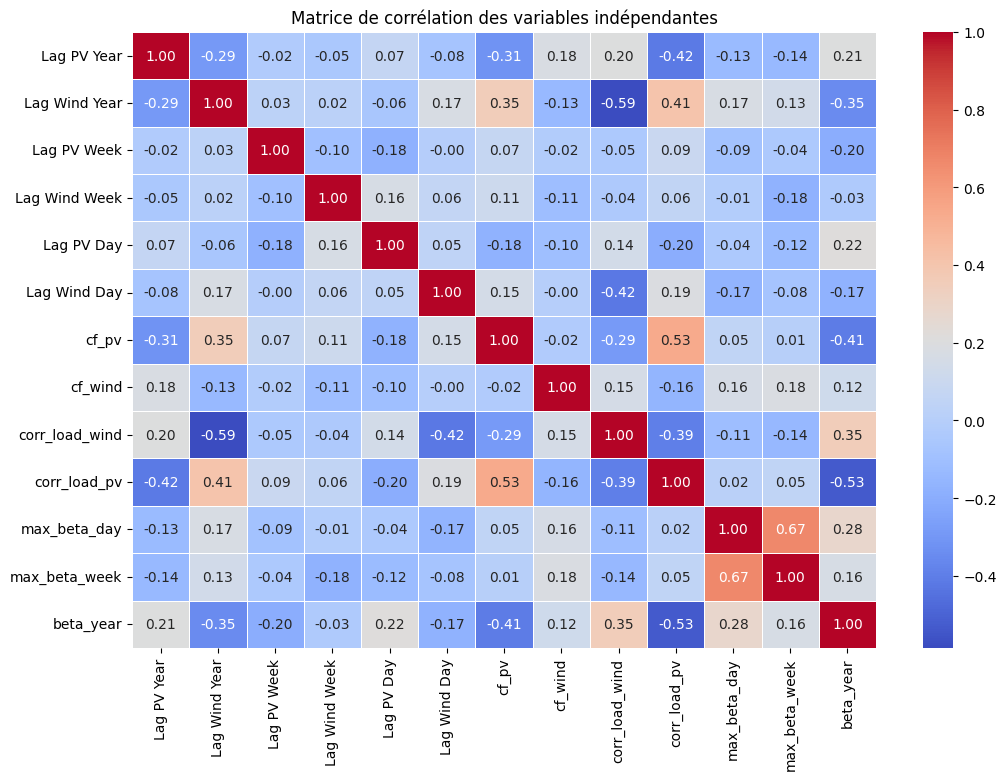

In [38]:
# Calcul de la matrice de corrélation
correlation_matrix = X.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables indépendantes')
plt.show()

Erreur quadratique moyenne (MSE) : 0.005541613717951761
Coefficient de détermination (R^2) : 0.8009403241653973

Importance des variables (permutation importance) :
Lag PV Year: Importance moyenne = 0.0259, Ecart-type = 0.0125
Lag Wind Year: Importance moyenne = 0.0047, Ecart-type = 0.0066
Lag PV Week: Importance moyenne = -0.0033, Ecart-type = 0.0048
Lag Wind Week: Importance moyenne = 0.0014, Ecart-type = 0.0032
Lag PV Day: Importance moyenne = 0.0060, Ecart-type = 0.0049
Lag Wind Day: Importance moyenne = -0.0001, Ecart-type = 0.0039
cf_pv: Importance moyenne = 0.6024, Ecart-type = 0.1186
cf_wind: Importance moyenne = 0.2223, Ecart-type = 0.0374
corr_load_wind: Importance moyenne = 0.0337, Ecart-type = 0.0158
corr_load_pv: Importance moyenne = 0.0189, Ecart-type = 0.0083
max_beta_day: Importance moyenne = 0.0001, Ecart-type = 0.0031
max_beta_week: Importance moyenne = 0.0044, Ecart-type = 0.0020
beta_year: Importance moyenne = 0.0068, Ecart-type = 0.0053


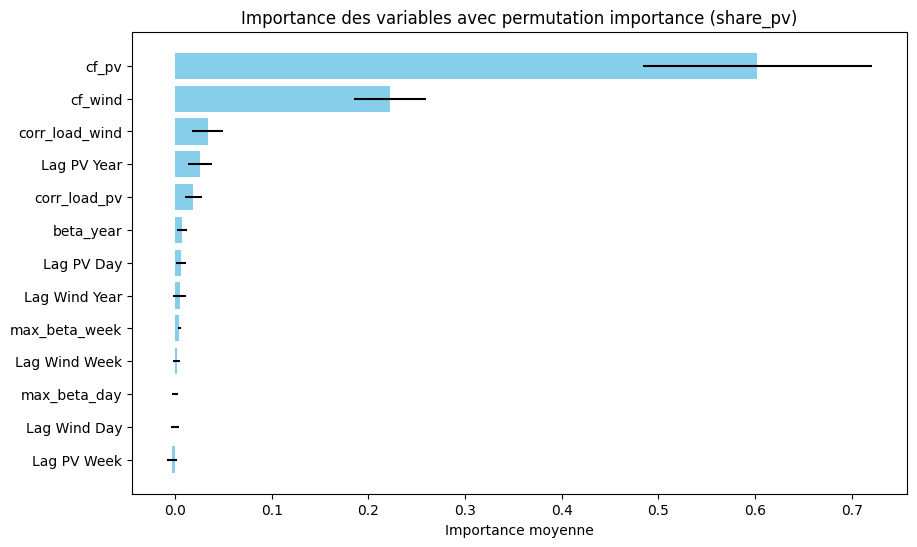

In [39]:
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R^2) :", r2)
print("\nImportance des variables (permutation importance) :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance moyenne = {result.importances_mean[i]:.4f}, Ecart-type = {result.importances_std[i]:.4f}")


sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], color='skyblue')
plt.xlabel('Importance moyenne')
plt.title('Importance des variables avec permutation importance (share_pv)')
plt.show()

Mean Squared Error: 0.007058068902334263
Mean Absolute Error: 0.06813207816115673
Coefficient de détermination (R^2) : 0.7397517599302774


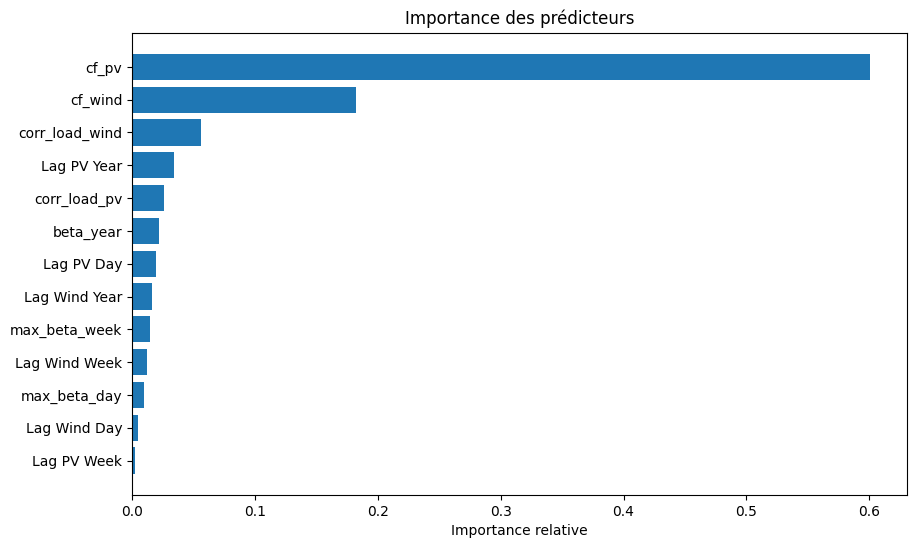

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print("Coefficient de détermination (R^2) :", r2)
importances = model.feature_importances_



indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Importance des prédicteurs")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X.columns[sorted_idx])
plt.xlabel("Importance relative")
plt.show()